In [172]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

In [496]:
LOCAL_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/energy_generation_data/df_deutschland.csv'

def get_target_data(path=LOCAL_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('daily/','hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()    
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

target_df = get_target_data(target='wind', hourly=False)


## Features

In [467]:
FEATURES_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/features'

def get_features_data(path=FEATURES_PATH, features=['wind'], hourly=False):
    if hourly:
        path = FEATURES_PATH.replace('/daily/','/hourly/')
    if 'wind' in features:
        path = path.replace('features','features/winddailyofeverystation.csv')
        wind_df = pd.read_csv(path, index_col='Date')
        wind_df.index = pd.to_datetime(wind_df.index)
        wind_df = wind_df.sum(axis=1)
    return wind_df
        
features_df = get_features_data()

##  Forecasted

In [497]:
FORCASTED_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/forecasted_generation_data/df_deutschland_forecasted.csv'

def get_forcasted_data(path=FORCASTED_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('/daily/', '/hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

forcasted_df = get_forcasted_data(target='wind', hourly=False)
    

In [482]:
#forecasted_df.loc[dt.date(2018,1,1):dt.date(2018,3,1)]

# Statistical exploration

## Train Test Split

In [506]:
def get_X_y(target_df, features_df, init_date=dt.datetime(2015,1,1), end_date=dt.datetime(2016,1,1)):
    X = features_df.loc[init_date:end_date]
    y = target_df.loc[init_date:end_date]
    return X, y

X, y = get_X_y(target_df, features_df, init_date=dt.date(2015,1,1), end_date=dt.date(2016,4,1))

In [542]:
def train_test_split(X, y, train_size=0.8):
    index = round(train_size*len(X))
    X_train = X.iloc[:index]
    X_test = X.iloc[index:]
    y_train = y.iloc[:index]
    y_test = y.iloc[index:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Stationarity

### Visually

<AxesSubplot:>

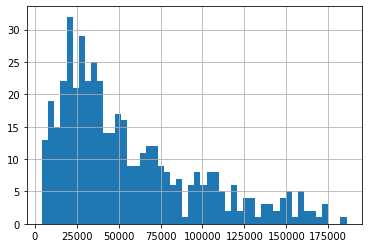

In [544]:
y.hist(bins=50)

<AxesSubplot:xlabel='Date'>

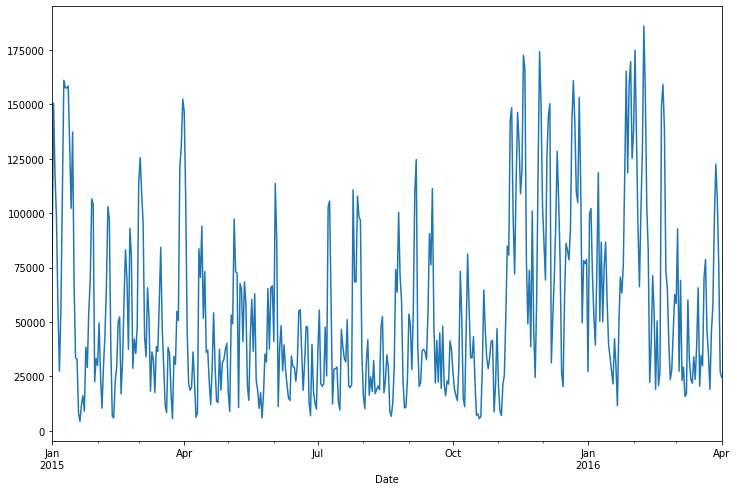

In [545]:
plt.subplots(figsize=(12,8))
y.plot()

###  Calculations (mean, variance and autocorrelation)

In [72]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m)
    if d > 0:
        for i in range(d):
            y = y.diff(1)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

In [546]:
y.mean()

56005.67377826404

In [547]:
# p-value (should be less than 0.05 to be sattionary)
adfuller(y_train)[1]

2.2909818909466313e-07

In [548]:
y.var()

1684902349.9302764

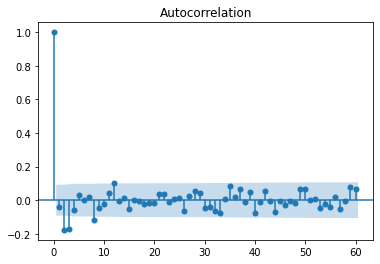

In [549]:
plot_acf(y.diff(1).dropna(), lags=60);

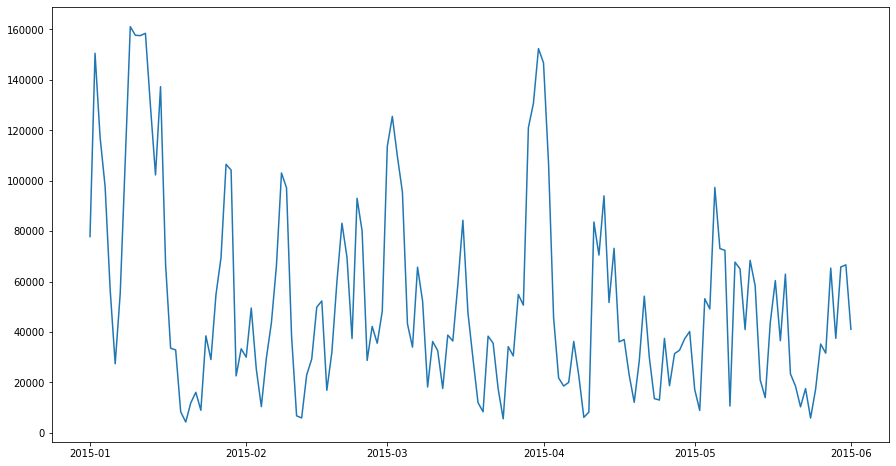

In [550]:
plt.subplots(figsize=(15,8))
plt.plot(y.loc[:dt.date(2015,6,1)])

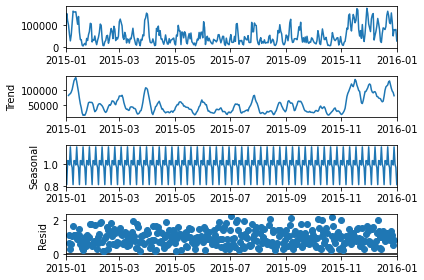

In [584]:
result_mul = seasonal_decompose(y_train, model='multiplicative')
result_mul.plot();

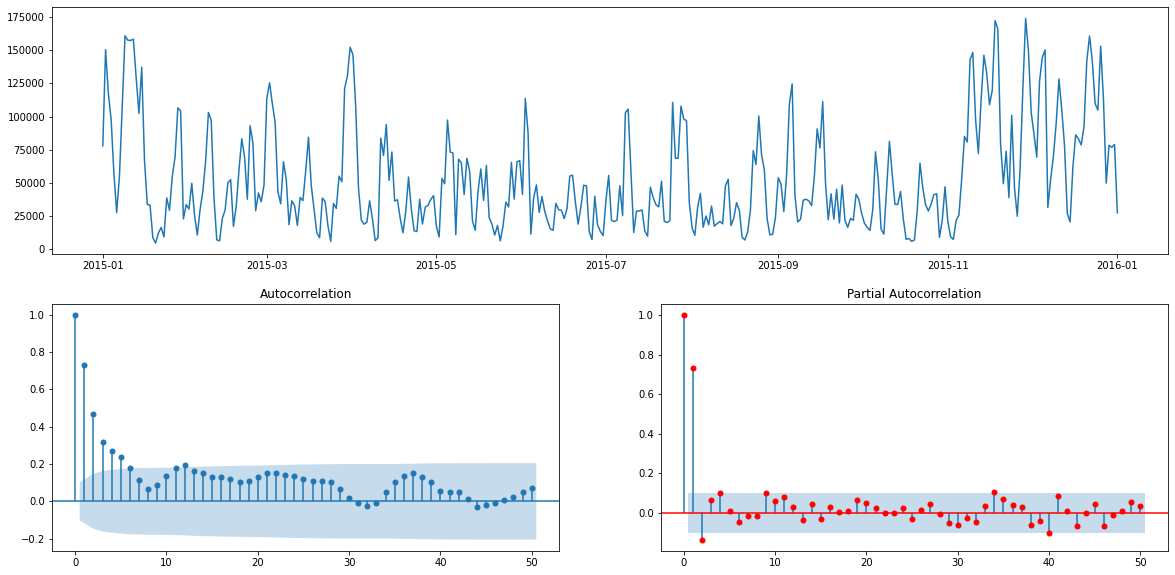

In [552]:
plot_autocorrelation(y_train, D=0, m=365*5)

In [555]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=12, X=X_train.to_numpy().reshape(-1,1),
                       start_p=0, max_p=2,
                       start_q=0, max_q=5,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7808.040, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7791.951, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7780.031, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9595.504, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7779.372, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=7780.200, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7745.226, Time=0.17 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=7745.841, Time=0.56 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=7745.708, Time=0.65 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7792.076, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=7747.171, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept

# Models

## ARIMA

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA

# arima = ARIMA(y_train, order=(1,1,2)).fit()
# arima.summary()

In [557]:
sarimax = SARIMAX(endog=y_train, exog=X_train, order=(2,1,2)).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible startin

In [531]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [558]:
forecast = sarimax.forecast(len(y_test), exog=X_test, alpha=0.05)

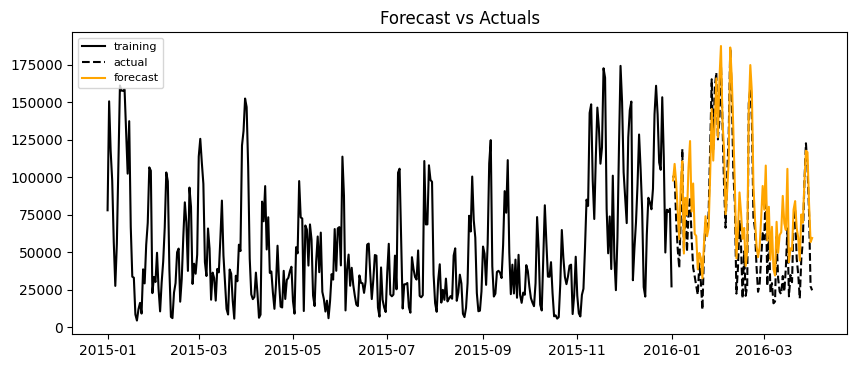

In [560]:
plot_forecast(forecast, y_train, y_test)

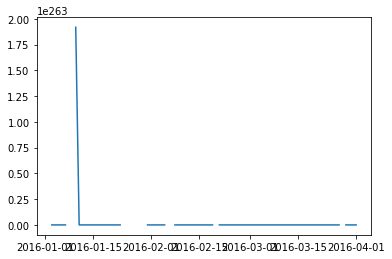

In [563]:
residuals = y_test - forecast
plt.plot(np.exp(residuals))

In [566]:
sarimax.mae

7332.078561703553

In [567]:
mae(y_test, forecast)

19067.87005384412

In [568]:
sarimax.mse

95044627.5102593

In [571]:
mse(y_test, forecast)

507506704.42673576

In [572]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [575]:
# asbolute values MAPE
baseline = mean_absolute_percentage_error(y_test, forecast)
baseline

51.46796947923254

In [576]:
# log values MAPE
log_baseline = mean_absolute_percentage_error(np.log(y_test), np.log(forecast))
log_baseline

3.509275903557846

In [582]:
# SMARD forcast MAPE
mean_absolute_percentage_error(y_test, forcasted_df.loc[dt.date(2016,1,1):dt.date(2016,3,31)])

355.6322624549975

In [410]:
# SMARD log forcast MAPE
THE_BAR = mean_absolute_percentage_error(y_test, np.log(mini_forecast))
THE_BAR

1.1962287415324098